In [2]:
import os
import pickle
import cupy as cp
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd

In [99]:
if cp.cuda.Device().id >= 0:
    print("CuPy is using CUDA (GPU)")
else:
    print("CuPy is NOT using CUDA (CPU)")

CuPy is using CUDA (GPU)


### Visualizing the Representational Dissimilarity Matrix (RDM)
LAYERS with 5k PCA components  0.95 variance- VIDEO DATA - resnet50
DISTANCE METRIC: CORRELATION

In [7]:
def compute_demo_rdm(demo_feature_matrix_path):
    feature_matrix = np.load(demo_feature_matrix_path, allow_pickle=True)
    feature_matrix = np.squeeze(feature_matrix)
    dissimilarities = pdist(feature_matrix, metric='correlation')
    return squareform(dissimilarities)

In [8]:
def plot_rdm_from_file(file_path):
    # Compute RDM using compute_demo_rdm function
    rdm = compute_demo_rdm(file_path)
    
    # Plot RDM
    plt.figure(figsize=(8, 8)) 
    plt.imshow(rdm, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('Representational Dissimilarity Matrix')
    plt.xlabel('Video Index')
    plt.ylabel('Video Index')
    plt.show()

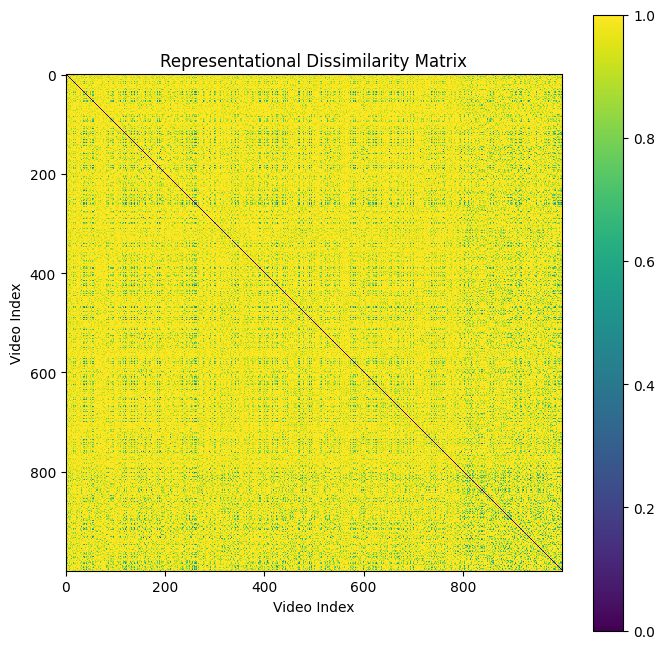

In [10]:
# Load feature matrix from layer .npy file 
stage_1 = plot_rdm_from_file(r"C:\Users\andre\Downloads\PCA_filter_0.95\stage_1\layer_1_pca.pkl")

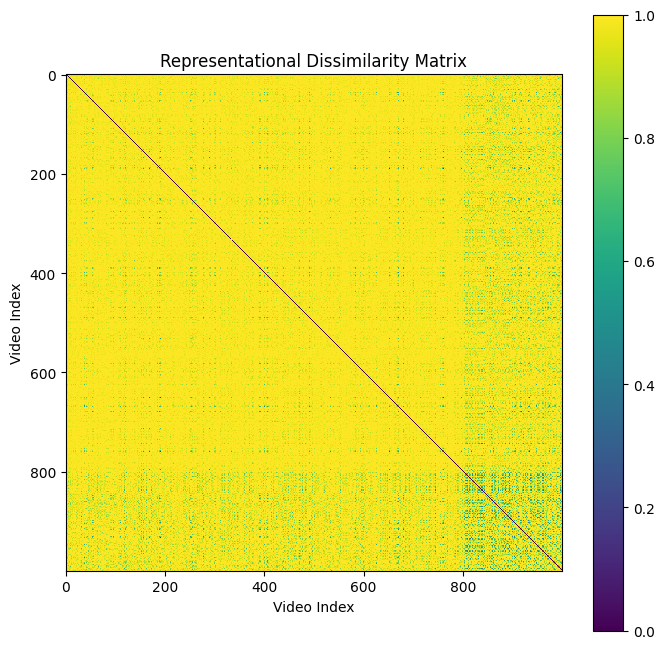

In [11]:
stage_2 = plot_rdm_from_file(r"C:\Users\andre\Downloads\PCA_filter_0.95\stage_2\layer_2_pca.pkl")

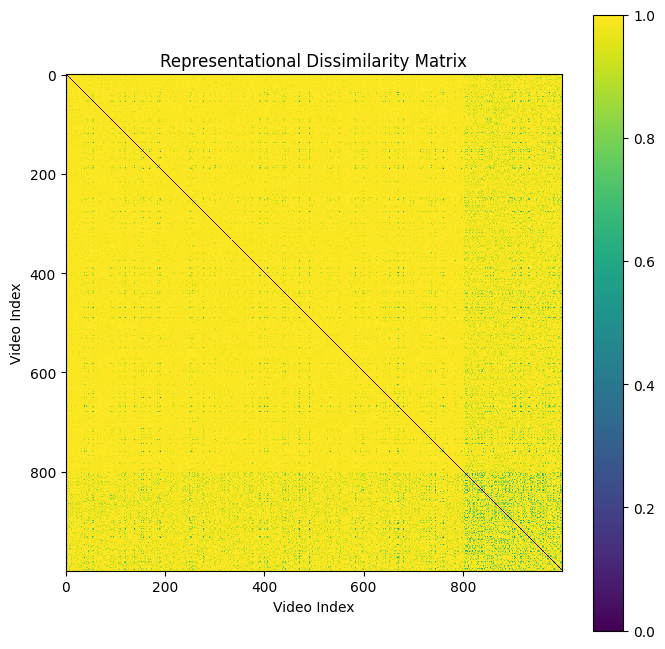

In [12]:
stage_3 = plot_rdm_from_file(r"C:\Users\andre\Downloads\PCA_filter_0.95\stage_3\layer_3_pca.pkl")

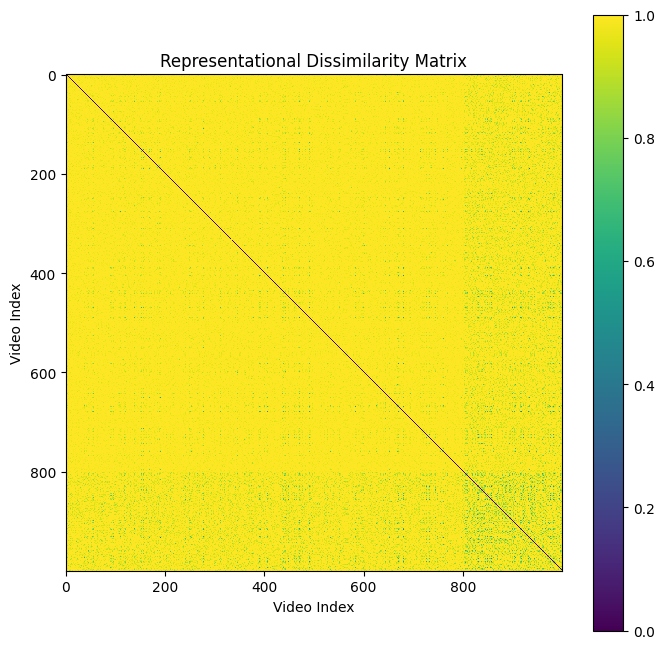

In [13]:
stage_4 = plot_rdm_from_file(r"C:\Users\andre\Downloads\PCA_filter_0.95\stage_4\layer_4_pca.pkl")

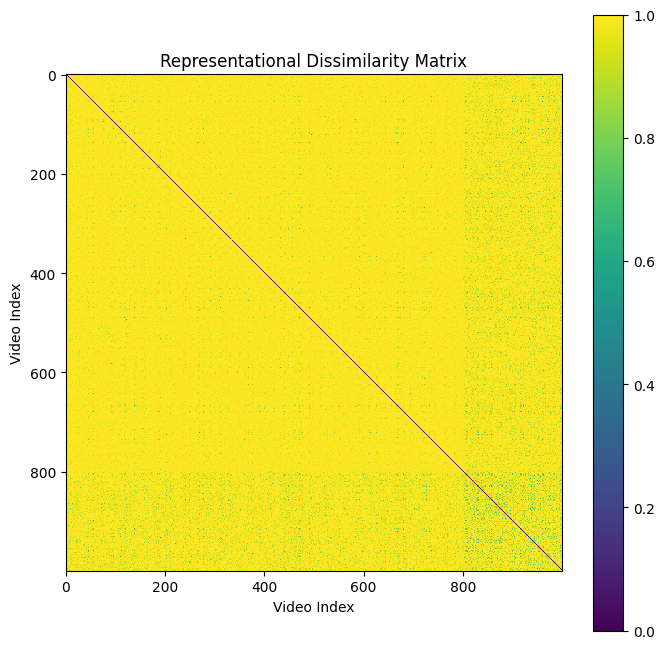

In [15]:
stage_5 = plot_rdm_from_file(r"C:\Users\andre\Downloads\PCA_filter_0.95\stage_5\layer_5_pca.pkl")

### Visualizing the Representational Dissimilarity Matrix (RDM)
MINITRACK BRAIN REGIONS - fMRI DATA
Calculation per subject_ROI and average of 10 subjects
DISTANCE METRIC: CORRELATION

In [82]:
def load_fmri_data(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    return data

In [83]:
EBA = load_fmri_data(r"C:\Users\andre\OneDrive\Documents\GitHub\algonuts_2021_andrea\participants_data_v2021\mini_track\sub01\EBA.pkl")
EBA

{'train': array([[[ 0.25350905, -0.57726972, -0.72763889, ..., -0.53123644,
          -0.34700944, -0.87076372],
         [ 0.05788916,  0.63083047,  0.23448168, ..., -0.64568988,
           0.6862889 ,  1.375431  ],
         [ 0.4457479 ,  0.53338382,  0.8011759 , ..., -0.07184202,
          -0.22447055,  1.25935497]],
 
        [[-0.07082054,  0.31476823,  0.78091551, ...,  1.64708868,
          -0.39030974, -0.98803645],
         [ 0.07481415, -1.49131826, -1.80791206, ..., -0.12425088,
           0.2371683 ,  0.30824879],
         [ 0.70634331,  1.18879755,  1.47346919, ...,  2.0978929 ,
           0.36594909,  0.54469543]],
 
        [[-0.16342703,  0.6136947 ,  1.24991946, ...,  0.41614041,
           1.33278728,  0.79487135],
         [ 0.16059268,  1.32079498,  0.26641557, ...,  0.12688588,
          -1.28358604, -0.51885571],
         [ 0.09119704,  0.16278261, -0.10883891, ...,  0.91686967,
           1.47686719,  0.64339875]],
 
        ...,
 
        [[-0.15063514, -0.11053

In [84]:
"""Compute RDM without using GPU"""
def compute_rdm(data):
    # Assuming data is a 3D array: conditions/time points x voxels x features
    n_conditions = data.shape[0]
    rdm = np.zeros((n_conditions, n_conditions))
    for i in range(n_conditions):
        for j in range(n_conditions):
            if i != j:
                # Flatten the voxel and feature dimensions to compute correlation over all features
                flat_i = data[i].flatten()
                flat_j = data[j].flatten()
                correlation, _ = pearsonr(flat_i, flat_j)
                rdm[i, j] = 1 - correlation
            else:
                rdm[i, i] = 0  # Dissimilarity with itself is 0
    return rdm

In [106]:
"""Compute RDM using GPU"""
def pearson_correlation_cupy(x, y):
    """Compute Pearson correlation coefficient using CuPy."""
    mean_x = cp.mean(x)
    mean_y = cp.mean(y)
    xm = x - mean_x
    ym = y - mean_y
    r_num = cp.sum(xm * ym)
    r_den = cp.sqrt(cp.sum(xm ** 2) * cp.sum(ym ** 2))
    r = r_num / r_den
    return r

def compute_rdm_gpu(data):
    # Convert input data to CuPy array for GPU computation
    data_gpu = cp.asarray(data)
    n_conditions = data_gpu.shape[0]
    rdm = cp.zeros((n_conditions, n_conditions), dtype=cp.float32)
    
    for i in range(n_conditions):
        for j in range(i + 1, n_conditions):  # Use symmetry to halve the computation
            flat_i = data_gpu[i].ravel()
            flat_j = data_gpu[j].ravel()
            correlation = pearson_correlation_cupy(flat_i, flat_j)
            dissimilarity = 1 - correlation
            rdm[i, j] = dissimilarity
            rdm[j, i] = dissimilarity  # Exploit symmetry
            
    cp.fill_diagonal(rdm, 0)  # Dissimilarity with itself is 0
    
    # Convert RDM back to a NumPy array if further processing is done on CPU
    rdm_cpu = cp.asnumpy(rdm)
    return rdm_cpu

In [107]:
# Folder path where your pickle files are stored
folder_path = (r'C:\Users\andre\OneDrive\Documents\GitHub\algonuts_2021_andrea\participants_data_v2021\mini_track')

In [ ]:
# Dictionary to hold RDMs for each ROI
# Process each subject's folder
for subject_folder in tqdm(os.listdir(folder_path), desc="Processing subjects"):
    subject_path = os.path.join(folder_path, subject_folder)
    if os.path.isdir(subject_path):  # Ensure it's a directory
        # Process each .pkl file within the subject's folder
        for file in os.listdir(subject_path):
            if file.endswith(".pkl"):
                full_file_path = os.path.join(subject_path, file)
                fmri_data_dict = load_fmri_data(full_file_path)
                fmri_data = fmri_data_dict.get('train', np.array([]))
                if fmri_data.size > 0:
                    rdm = compute_rdm_gpu(fmri_data) # Compute RDM using GPU 
                    roi_name = os.path.splitext(file)[0]
                    
                    # Define the filename for the RDM .npy file
                    output_filename = f"{subject_folder}_{roi_name}_rdm.npy"
                    output_filepath = os.path.join(folder_path, output_filename)
                    
                    # Save the RDM to a .npy file
                    np.save(output_filepath, rdm)

print("RDM computation and saving completed.")

Processing subjects:  30%|███       | 3/10 [1:04:03<2:30:18, 1288.36s/it]

### Averaging the RDMs across subjects

In [28]:
# Define the directory where your ROI files are located
roi_rdms_path = r"C:\Users\andre\OneDrive\Documents\GitHub\Brainvision_Project\Task5 - RSA\ROI_sub_RDMS"

# Define a dictionary to store average RDMs for each ROI
average_rdms = {}

# Define a list of ROI names
roi_names = ["EBA", "FFA", "LOC", "PPA", "STS", "V1", "V2", "V3", "V4"]

# Loop through each ROI
for roi_name in roi_names:
    # List files in the directory matching the current ROI
    roi_files = [file for file in os.listdir(roi_rdms_path) if roi_name in file]

    # Ensure there are exactly 10 files for the ROI
    if len(roi_files) != 10:
        print(f"Warning: Not enough files found for {roi_name}. Skipping...")
        continue

    # Initialize a list to store RDMs for each subject
    subject_rdms = []

    # Load and average RDMs for each subject
    for file_name in roi_files:
        file_path = os.path.join(roi_rdms_path, file_name)
        rdm = np.load(file_path)
        subject_rdms.append(rdm)

    # Average RDMs across subjects
    average_rdm = np.average(subject_rdms, axis=0)

    # Store the average RDM in the dictionary
    average_rdms[roi_name] = average_rdm

# Save the dictionary of average RDMS to a file
np.save("average_rdms.npy", average_rdms)

In [21]:
def plot_rdm_from_dict(file_path, roi_name):
    # Load the dictionary of RDMs from .npy file
    rdms = np.load(file_path, allow_pickle=True).item()
    
    # Extract the specific RDM using the ROI name
    feature_matrix = rdms[roi_name]
    
    # Assuming the RDM is already computed, directly plot it
    plt.figure(figsize=(8, 8)) 
    plt.imshow(feature_matrix, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar()
    plt.title(f'Representational Dissimilarity Matrix: {roi_name}')
    plt.xlabel('Condition/Index')
    plt.ylabel('Condition/Index')
    plt.show()

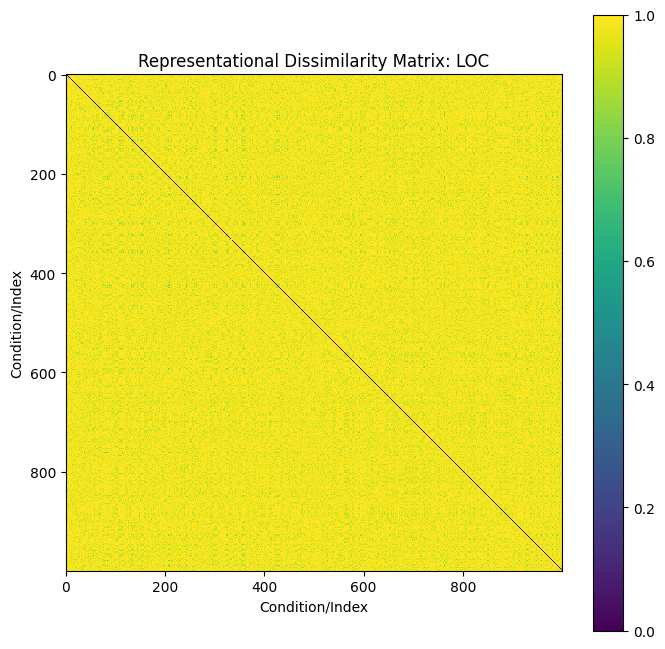

In [24]:
plot_rdm_from_dict('average_rdms.npy', 'LOC')

In [35]:
def plot_rdm_from_file(file_path):
    # Load the RDM values directly from the file
    rdms = np.load(file_path)
    
    # Plot the RDM
    plt.figure(figsize=(8, 8))
    plt.imshow(rdms, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('Representational Dissimilarity Matrix')
    plt.xlabel('Condition/Index')
    plt.ylabel('Condition/Index')
    plt.show()

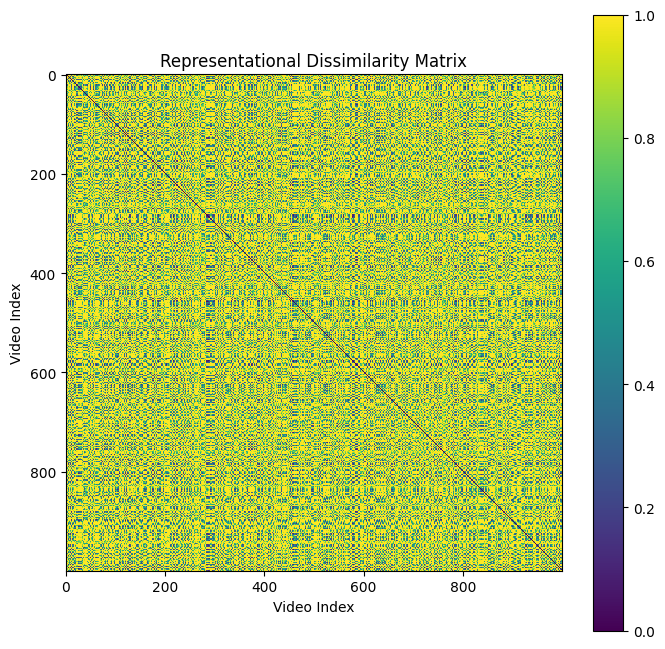

In [29]:
file_path = r"C:\Users\andre\OneDrive\Documents\GitHub\Brainvision_Project\Task5 - RSA\ROI_sub_RDMS\sub07_LOC_rdm.npy"
plot_rdm_from_file(file_path)

### RSA Analysis
Comparing each ROI per subject to selected layer

In [53]:
def rsa_score_spearman(demo_rdm, subject_rdm):
    original_score, _ = spearmanr(demo_rdm.flatten(), subject_rdm.flatten())
    return original_score

In [54]:
# Load the selected RDM
demo_feature_matrix_path = r"C:\Users\andre\Downloads\PCA_filter_0.95\stage_5\layer_5_pca.pkl"
demo_rdm = compute_demo_rdm(demo_feature_matrix_path)

In [55]:
# Define subjects and ROIs
subjects = [f"sub{str(i).zfill(2)}" for i in range(1, 11)]  # sub_01 to sub_10
roi_names = ["EBA", "FFA", "LOC", "PPA", "STS", "V1", "V2", "V3", "V4"]
folder_path = r"C:\Users\andre\OneDrive\Documents\GitHub\Brainvision_Project\Task5 - RSA\ROI_sub_RDMS"  # Adjust this path

In [57]:
# Prepare a list to store RSA results
rsa_results = []

# Loop through each subject and ROI to compute RSA 
for subject in tqdm(subjects, desc="Subjects"):
    for roi in tqdm(roi_names, desc="ROIs", leave=False):
        rdm_path = os.path.join(folder_path, f"{subject}_{roi}_rdm.npy")
        if os.path.exists(rdm_path):
            subject_rdm = np.load(rdm_path)
            rsascore = rsa_score_spearman(demo_rdm, subject_rdm)
            rsa_results.append([subject, roi, rsascore])
        else:
            print(f"File not found: {rdm_path}")

# Convert the results into a DataFrame
rsa_df = pd.DataFrame(rsa_results, columns=['Subject', 'ROI', 'RSA_Score'])
# Correct the path to include the filename and .csv extension
results_csv_path = r"C:\Users\andre\OneDrive\Documents\GitHub\Brainvision_Project\Task5 - RSA\ROI_sub_RDMS\rsa_stage5.csv"

# Then try saving again
rsa_df.to_csv(results_csv_path, index=False)
print("RSA analysis completed and results saved to CSV.")

Subjects: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]

RSA analysis completed and results saved to CSV.
